### English to French Conversion using RNN's

In [42]:
import collections

import helper
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

#### Load Data

In [43]:
# Load English data
english_sentences = helper.load_data('C:\\Users\\KITS\\English2FrenchConversionRNN\\small_vocab_en')
# Load French data
french_sentences = helper.load_data('C:\\Users\\KITS\\English2FrenchConversionRNN\\small_vocab_fr')

In [44]:
print(english_sentences[0])
print(french_sentences[0])


new jersey is sometimes quiet during autumn , and it is snowy in april .
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


In [45]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('French sample {}:  {}\n'.format(sample_i + 1, french_sentences[sample_i]))

English sample 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
French sample 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English sample 2:  the united states is usually chilly during july , and it is usually freezing in november .
French sample 2:  les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .

English sample 3:  california is usually quiet during march , and it is usually hot in june .
French sample 3:  california est gÃ©nÃ©ralement calme en mars , et il est gÃ©nÃ©ralement chaud en juin .

English sample 4:  the united states is sometimes mild during june , and it is cold in september .
French sample 4:  les Ã©tats-unis est parfois lÃ©gÃ¨re en juin , et il fait froid en septembre .

English sample 5:  your least liked fruit is the grape , but my least liked is the apple .
French sample 5:  votre moins aimÃ© fruit est le raisin , mais mon moins aimÃ© est la pomme .



#### Convert to Vocabulary

In [46]:
import collections

In [47]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('English Vocab:',len(english_words_counter))
print('French Vocab:',len(french_words_counter))

English Vocab: 227
French Vocab: 355


In [48]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [49]:
# Tokenize Sample output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']

text_tokenized,text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)

for sample_i,(sent,token_sent) in enumerate(zip(text_sentences,text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}
Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [50]:
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')

In [51]:
text_sentences = ['The quick brown fox jumps over the lazy dog .']
text_tokenized,text_tokenizer = tokenize(text_sentences)
preprocess_eng = pad(text_tokenized)
print(preprocess_eng)
print(type(preprocess_eng))
preprocess_eng = preprocess_eng.reshape(*preprocess_eng.shape,1)
print(preprocess_eng)

[[1 2 3 4 5 6 1 7 8]]
<class 'numpy.ndarray'>
[[[1]
  [2]
  [3]
  [4]
  [5]
  [6]
  [1]
  [7]
  [8]]]


In [52]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    
    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    #Expanding dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    
    return preprocess_x, preprocess_y, x_tk, y_tk


preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index) 

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)
    
    

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


In [53]:
preproc_english_sentences[0:5]

array([[17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0],
       [ 5, 20, 21,  1,  9, 62,  4, 43,  7,  3,  1,  9, 51,  2, 45],
       [22,  1,  9, 67,  4, 38,  7,  3,  1,  9, 68,  2, 34,  0,  0],
       [ 5, 20, 21,  1,  8, 64,  4, 34,  7,  3,  1, 57,  2, 42,  0],
       [29, 12, 16, 13,  1,  5, 82,  6, 30, 12, 16,  1,  5, 83,  0]])

In [54]:
preproc_french_sentences[0:5]

array([[[ 35],
        [ 34],
        [  1],
        [  8],
        [ 67],
        [ 37],
        [ 11],
        [ 24],
        [  6],
        [  3],
        [  1],
        [112],
        [  2],
        [ 50],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  4],
        [ 32],
        [ 31],
        [  1],
        [ 12],
        [ 19],
        [  2],
        [ 49],
        [  6],
        [  3],
        [ 95],
        [ 69],
        [  2],
        [ 51],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[101],
        [  1],
        [ 12],
        [ 67],
        [  2],
        [ 45],
        [  6],
        [  3],
        [  1],
        [ 12],
        [ 21],
        [  2],
        [ 41],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  4],
        [ 32],
        [ 31],
    

### Building models

- Model 1 : Simple RNN
- Model 2 : RNN with Embedding Model
- Model 3 : Bidirectional RNN
- Model 4 : Encoder-Decoder RNN 

### IDs to Text

We need to predict the french translaion of english context. For english context we obtain the probabilites of the respective french translation. The french translation having highest probability predicted by the model will be our corresponding french prediction.

In [55]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])    

In [56]:
def embed_model(input_shape, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.005
    
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 
    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
    

In [58]:
preproc_french_sentences.shape

(137861, 21, 1)

In [59]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
print(tmp_x[0])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))
print(tmp_x[0])

[17 23  1  8 67  4 39  7  3  1 55  2 44  0  0  0  0  0  0  0  0]
[17 23  1  8 67  4 39  7  3  1 55  2 44  0  0  0  0  0  0  0  0]


In [60]:
tmp_x

array([[17, 23,  1, ...,  0,  0,  0],
       [ 5, 20, 21, ...,  0,  0,  0],
       [22,  1,  9, ...,  0,  0,  0],
       ...,
       [24,  1, 10, ...,  0,  0,  0],
       [ 5, 84,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [61]:
tmp_x.shape[1]

21

In [64]:
tmp_x.shape

(137861, 21)

In [62]:
english_vocab_size = len(english_tokenizer.word_index)+1
french_vocab_size = len(french_tokenizer.word_index)+1

In [65]:
french_vocab_size

346

In [66]:
simple_rnn_model = embed_model(tmp_x.shape,english_vocab_size,french_vocab_size)

In [67]:
simple_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 256)           51200     
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 256)           394752    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 1024)          263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 346)           354650    
Total params: 1,063,770
Trainable params: 1,063,770
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

Epoch 1/20
108/108 [==============================] - 250s 2s/step - loss: 1.3453 - accuracy: 0.6841 - val_loss: 0.4709 - val_accuracy: 0.8489
Epoch 2/20
108/108 [==============================] - 256s 2s/step - loss: 0.4042 - accuracy: 0.8684 - val_loss: 0.2980 - val_accuracy: 0.8995
Epoch 3/20
108/108 [==============================] - 248s 2s/step - loss: 0.2869 - accuracy: 0.9045 - val_loss: 0.2392 - val_accuracy: 0.9190
Epoch 4/20
108/108 [==============================] - 247s 2s/step - loss: 0.2420 - accuracy: 0.9182 - val_loss: 0.2150 - val_accuracy: 0.9261
Epoch 5/20
108/108 [==============================] - 255s 2s/step - loss: 0.2171 - accuracy: 0.9255 - val_loss: 0.2042 - val_accuracy: 0.9302
Epoch 6/20
108/108 [==============================] - 254s 2s/step - loss: 0.2031 - accuracy: 0.9294 - val_loss: 0.1929 - val_accuracy: 0.9326
Epoch 7/20
108/108 [==============================] - 251s 2s/step - loss: 0.1949 - accuracy: 0.9317 - val_loss: 0.1872 - val_accuracy: 0.9343

In [69]:
simple_rnn_model.save('simple_rnn_model.h5')


In [73]:
import matplotlib.pyplot as plt

In [74]:
print(history.history['val_loss'])

[0.47085702419281006, 0.2980496883392334, 0.23919250071048737, 0.21500824391841888, 0.20417258143424988, 0.1929040253162384, 0.1871962994337082, 0.18409694731235504, 0.18211981654167175, 0.17968323826789856, 0.18032242357730865, 0.1775401085615158, 0.17643485963344574, 0.17655494809150696, 0.18213587999343872, 0.17927062511444092, 0.18006785213947296, 0.18151937425136566, 0.17988371849060059, 0.17791879177093506]


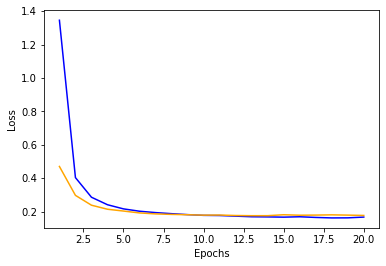

In [80]:
epochs = range(1,21)
plt.plot(epochs,history.history['loss'],color = 'blue')
plt.plot(epochs,history.history['val_loss'],color = 'orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


### Test

In [82]:
tmp_x[:1]

array([[17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0,  0,
         0,  0,  0,  0,  0]])

In [86]:
simple_rnn_model.predict(tmp_x[:1]).shape

(1, 21, 346)

In [89]:
simple_rnn_model.predict(tmp_x[:1])[0]

array([[2.8925592e-14, 7.6203014e-13, 8.4322063e-12, ..., 1.4884486e-17,
        8.2731180e-20, 1.0723879e-17],
       [1.4881109e-10, 6.9524351e-09, 5.4341729e-11, ..., 7.5713344e-17,
        5.0944681e-18, 2.4591777e-17],
       [3.4811737e-07, 9.8078030e-01, 1.5126050e-09, ..., 1.9428909e-12,
        1.1860322e-10, 7.5163297e-13],
       ...,
       [1.0000000e+00, 7.6368651e-12, 6.0894095e-11, ..., 1.5982250e-25,
        7.0054264e-24, 1.3154517e-25],
       [1.0000000e+00, 2.3038233e-11, 2.7966174e-10, ..., 1.8668046e-25,
        7.3870497e-24, 1.8331991e-25],
       [1.0000000e+00, 3.6015649e-11, 5.3541595e-11, ..., 5.2763011e-26,
        1.8804210e-24, 4.8330959e-26]], dtype=float32)

In [90]:
simple_rnn_model.predict(tmp_x[:1])[0][0]

array([2.89255924e-14, 7.62030142e-13, 8.43220632e-12, 7.75400579e-08,
       1.54215104e-14, 2.22170815e-08, 1.24172876e-08, 1.70237979e-09,
       2.29971410e-18, 1.05329330e-11, 1.90893008e-08, 1.07144545e-13,
       5.92844236e-16, 4.92279074e-15, 8.65869339e-18, 1.79622463e-12,
       1.79209119e-19, 1.64813268e-19, 3.92241809e-19, 1.35338381e-23,
       2.26111122e-12, 1.62339262e-18, 2.52113406e-08, 2.26382609e-19,
       1.58535702e-11, 1.32894943e-16, 1.99650084e-12, 8.54265636e-09,
       3.10122287e-17, 1.12546993e-10, 1.54831279e-19, 1.08269743e-16,
       7.33187122e-12, 9.05741988e-19, 1.02173246e-07, 9.99999762e-01,
       1.81187300e-13, 2.90591646e-16, 1.72811035e-20, 1.45748603e-14,
       3.01090227e-18, 4.78509808e-21, 1.51043779e-14, 5.80404512e-17,
       2.09466450e-18, 8.89756206e-19, 3.07996956e-15, 1.09460360e-16,
       5.79189409e-20, 5.21254989e-23, 6.56068575e-16, 6.89494983e-16,
       5.23583986e-18, 2.01929245e-15, 2.40765621e-16, 1.02100850e-13,
      

In [92]:
print('English')
print(english_sentences[:1])
print('-----------------------------------')
print('Actual French')
print(french_sentences[:1])
print('-----------------------------------')
print('Predicted French')
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

English
['new jersey is sometimes quiet during autumn , and it is snowy in april .']
-----------------------------------
Actual French
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]
-----------------------------------
Predicted French
new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [96]:
french_tokenizer.word_index.items()

dict_items([('est', 1), ('en', 2), ('il', 3), ('les', 4), ('mais', 5), ('et', 6), ('la', 7), ('parfois', 8), ('jamais', 9), ('le', 10), ("l'", 11), ('gã©nã©ralement', 12), ('moins', 13), ('aimã©', 14), ('au', 15), ('fruit', 16), ('prã©fã©rã©', 17), ('agrã©able', 18), ('froid', 19), ('son', 20), ('chaud', 21), ('de', 22), ('plus', 23), ('automne', 24), ('mois', 25), ('ã\xa0', 26), ('elle', 27), ('citrons', 28), ('paris', 29), ('inde', 30), ('unis', 31), ('ã©tats', 32), ('france', 33), ('jersey', 34), ('new', 35), ('chine', 36), ('pendant', 37), ('pamplemousse', 38), ('mon', 39), ('votre', 40), ('juin', 41), ('printemps', 42), ('janvier', 43), ('hiver', 44), ('mars', 45), ('ã©tã©', 46), ('mai', 47), ('septembre', 48), ('juillet', 49), ('avril', 50), ('novembre', 51), ('dã©cembre', 52), ('fã©vrier', 53), ('octobre', 54), ('aime', 55), ('aoã»t', 56), ('merveilleux', 57), ('relaxant', 58), ('doux', 59), ('humide', 60), ('notre', 61), ('californie', 62), ('sec', 63), ('leur', 64), ('occupã©'

### Save Tokenizer

In [97]:
import pickle

In [98]:
with open('fr_tokenizer.pickle', 'wb') as handle:
    pickle.dump(french_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 